## Multi Head Attention

In [42]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [43]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn( (batch_size, sequence_length, input_dim) )

In [44]:
x.size()

torch.Size([1, 4, 512])

In [45]:
qkv_layer = nn.Linear(input_dim , 3 * d_model)

In [46]:
qkv = qkv_layer(x)

In [47]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

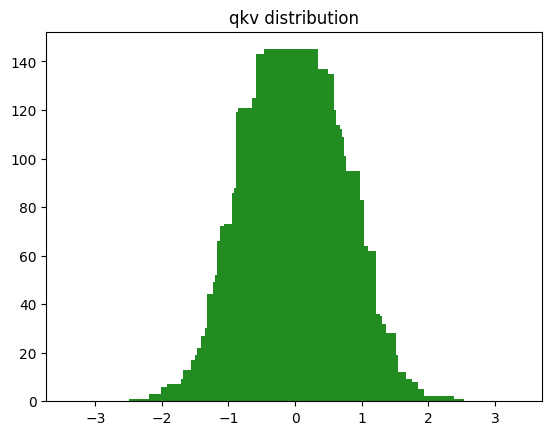

In [48]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [49]:
num_heads = 8
head_dim = d_model // num_heads #64 embedding for each head multiplied by qkv = 192
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [50]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [51]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [52]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

## Self Attention for multiple heads

For a single head:
$$
\text{self attention} = softmax\bigg(\frac{Q.K^T}{\sqrt{d_k}}+M\bigg)
$$

$$
\text{new V} = \text{self attention}.V
$$ 

In [53]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [54]:
k.T.shape

torch.Size([64, 4, 8, 1])

In [55]:
y = torch.randn(2, 3)
torch.transpose(y, 0, 1)

tensor([[ 0.1504, -1.0681],
        [ 0.8861,  0.1726],
        [ 0.4856, -0.1470]])

In [56]:
torch.transpose(y, 1, 0)

tensor([[ 0.1504, -1.0681],
        [ 0.8861,  0.1726],
        [ 0.4856, -0.1470]])

In [57]:
k.transpose(-1, -2) == k.transpose(-2, -1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [58]:
k.transpose(-1, -2).shape

torch.Size([1, 8, 64, 4])

In [59]:
scaled[0][0]

tensor([[ 0.0200,  0.6256, -0.6108,  0.1695],
        [ 0.0037,  0.2678, -0.3509,  0.3696],
        [-0.1952, -0.2389,  0.1352, -0.0622],
        [ 0.1101, -0.2016,  0.0023,  0.2882]], grad_fn=<SelectBackward0>)

In [60]:
mask = torch.full(scaled.size() , float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [61]:
(scaled + mask)[0][0]

tensor([[ 0.0200,    -inf,    -inf,    -inf],
        [ 0.0037,  0.2678,    -inf,    -inf],
        [-0.1952, -0.2389,  0.1352,    -inf],
        [ 0.1101, -0.2016,  0.0023,  0.2882]], grad_fn=<SelectBackward0>)

In [62]:
scaled += mask

In [63]:
np.exp(0.5596) / (np.exp(0.5596) + np.exp(0.0404))

0.6269606805367254

In [24]:
attention = F.softmax(scaled, dim=-1) # applied to last dimension where we have the scaled q.k/sqrt(d_K) + mask

In [25]:
attention.shape

torch.Size([1, 8, 4, 4])

In [26]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.3925, 0.6075, 0.0000, 0.0000],
        [0.2495, 0.3973, 0.3532, 0.0000],
        [0.2405, 0.3470, 0.1591, 0.2533]], grad_fn=<SelectBackward0>)

In [27]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

## Function

In [28]:
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [29]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [30]:
attention.shape

torch.Size([1, 8, 4, 4])

In [31]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.3925, 0.6075, 0.0000, 0.0000],
        [0.2495, 0.3973, 0.3532, 0.0000],
        [0.2405, 0.3470, 0.1591, 0.2533]], grad_fn=<SelectBackward0>)

In [32]:
values.size()

torch.Size([1, 8, 4, 64])

In [33]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [34]:
linear_layer = nn.Linear(d_model, d_model) # Enhances the learning between the multiple heads

In [35]:
out = linear_layer(values)

In [36]:
out.shape

torch.Size([1, 4, 512])

In [37]:
out

tensor([[[-0.0656,  0.2374, -0.6417,  ...,  0.4711, -0.1936,  0.2007],
         [-0.1008,  0.3384, -0.0220,  ..., -0.1258, -0.2615, -0.0764],
         [-0.1784,  0.0678,  0.2080,  ..., -0.0619,  0.0220,  0.1081],
         [ 0.0300, -0.0354,  0.0576,  ..., -0.2370, -0.1406,  0.3632]]],
       grad_fn=<ViewBackward0>)

## Class

In [38]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        mask = torch.full(scaled.size(), float('-inf'))
        mask = torch.triu(mask, diagonal=1)
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


## Input

In [39]:
input_dim = 1024 # initially set to this dimension
d_model = 512 # will be changed to this dimension in attention part
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x, mask) #masked

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])


In [40]:
out2 = model.forward(x) #not masked

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])


In [41]:
# masked, non-masked, comparison
out[0], out2[0], out[0] == out2[0]

(tensor([[ 0.3176, -0.0040,  0.3071,  ..., -0.0382,  0.1329, -0.0340],
         [-0.0601, -0.2045, -0.3739,  ..., -0.1530, -0.5675,  0.1420],
         [ 0.0588, -0.0132,  0.0071,  ...,  0.4090, -0.0879,  0.2907],
         [-0.5485, -0.3641,  0.0873,  ..., -0.3483, -0.5751, -0.1906],
         [ 0.1572, -0.3417, -0.0992,  ...,  0.1163,  0.3401, -0.4459]],
        grad_fn=<SelectBackward0>),
 tensor([[ 0.2391,  0.0062,  0.1749,  ..., -0.1664,  0.1065, -0.0905],
         [ 0.0513, -0.2075, -0.2506,  ..., -0.2206, -0.5062,  0.0621],
         [ 0.0206, -0.1346,  0.3154,  ...,  0.2878,  0.1045,  0.3338],
         [-0.4340, -0.0978, -0.0182,  ..., -0.0957, -0.1690,  0.2151],
         [ 0.2034, -0.2618, -0.1883,  ...,  0.0809,  0.2609, -0.1959]],
        grad_fn=<SelectBackward0>),
 tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., Fa